In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.stats import boxcox, yeojohnson
from statsmodels.tsa.seasonal import STL

In [8]:
data_dir = "./Data"
data_name = "Solar_Atl"
file_name = f"{data_dir}/{data_name}_data.csv"

In [9]:
data_df = pd.read_csv(file_name, skiprows=2)
# data_df.shape  # 8760, 14
data_df.drop(columns=data_df.columns[0:5], inplace=True)  # remove 5 temporal columns
data_df.drop(columns="Unnamed: 13", inplace=True)
# data_df.shape  # 8760, 8
target_column = "DHI"

In [10]:
data_df.shape

(8760, 8)

In [11]:
data_df

,DHI,DNI,Dew Point,Surface Albedo,Wind Speed,Relative Humidity,Temperature,Pressure
0,0,0,-12.3,0.11,1.9,59.45,-5.7,989
1,0,0,-12.6,0.11,1.8,59.64,-6.0,989
2,0,0,-12.7,0.11,1.8,60.25,-6.2,990
3,0,0,-12.8,0.11,1.9,60.54,-6.4,990
4,0,0,-13.2,0.11,1.9,60.17,-6.8,991
...,...,...,...,...,...,...,...,...
8755,0,0,-7.3,0.11,1.0,73.64,-3.3,987
8756,0,0,-8.3,0.11,1.5,71.91,-4.0,987
8757,0,0,-9.9,0.11,1.8,66.29,-4.6,987
8758,0,0,-11.0,0.11,1.8,63.41,-5.1,988


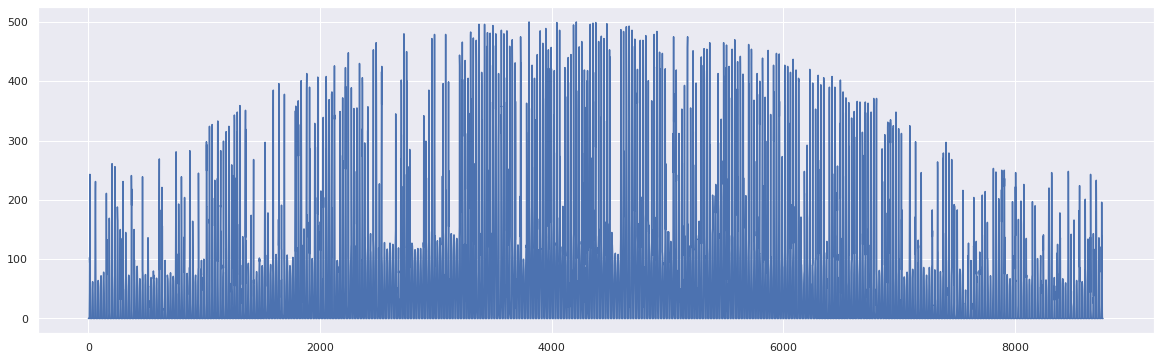

In [18]:
data_df[target_column].plot(figsize=(20, 6));

In [20]:
data_df[target_column].describe()

count    8760.000000
mean       69.306050
std       108.929644
min         0.000000
25%         0.000000
50%         0.000000
75%        99.000000
max       500.000000
Name: DHI, dtype: float64

**Decompose**

In [21]:
stl_model = STL(data_df[target_column], period=12, seasonal=13)

In [22]:
res = stl_model.fit()
seasonal = res.seasonal
trend = res.trend
residual = res.resid

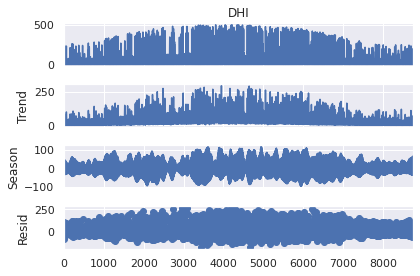

In [30]:
res.plot()
plt.show();

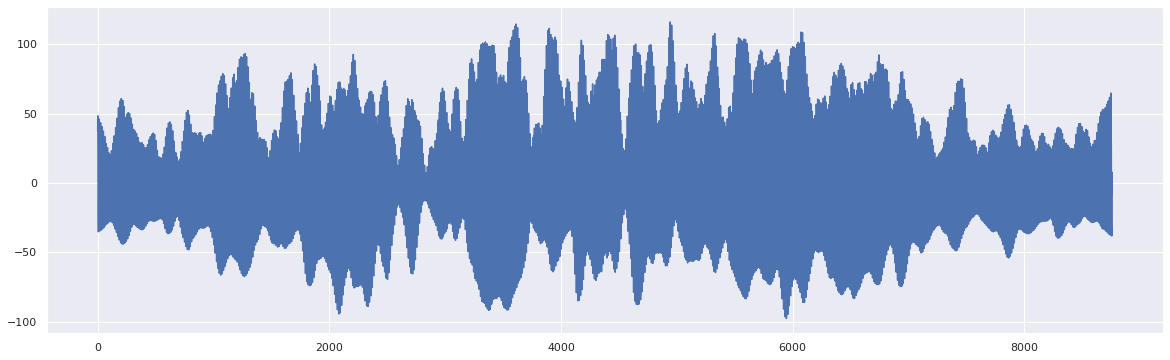

In [33]:
seasonal.plot(figsize=(20, 6));

In [34]:
recompose = seasonal + trend + residual

In [55]:
type(recompose)

pandas.core.series.Series

In [36]:
recompose.describe()

count    8760.000000
mean       69.306050
std       108.929644
min         0.000000
25%         0.000000
50%         0.000000
75%        99.000000
max       500.000000
dtype: float64

**Yeo-Johnson**

In [37]:
data_df[target_column]

0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: DHI, Length: 8760, dtype: int64

In [38]:
xt, lmbda = yeojohnson(data_df[target_column])

In [39]:
lmbda

-0.10886739694146672

In [41]:
data_df[target_column]

0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: DHI, Length: 8760, dtype: int64

In [42]:
xt

array([-0., -0., -0., ..., -0., -0., -0.])

In [46]:
xt = abs(xt)

In [47]:
xt.min(), xt.max()

(0.0, 4.516981160083704)

In [48]:
#Inverse Transform Yeojohnson Function
def invert_yeojhonson(value, lmbda):
    if value>= 0 and lmbda == 0:
        return exp(value) - 1
    elif value >= 0 and lmbda != 0:
        return (value * lmbda + 1) ** (1 / lmbda) - 1
    elif value < 0 and lmbda != 2:
        return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
    elif value < 0 and lmbda == 2:
        return 1 - exp(-value)

#Inverse Transform Function (in general)
def inverse_transform(data, lmbda, type_="yeojohnson"):
    if type_=="yeojohnson":
        inverted = [invert_yeojhonson(x, lmbda) for x in data]
    return inverted

In [50]:
invert = inverse_transform(xt, lmbda)

In [53]:
invert.min(), invert.max()

AttributeError: 'list' object has no attribute 'min'

In [52]:
data_df[target_column]

0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: DHI, Length: 8760, dtype: int64

In [54]:
type(data_df[target_column])

pandas.core.series.Series

**Bootstrapping the Residual**